In [1]:
import json
a = {'value1':5, 'value2':10, 'seq':[1, 2, 3, 4, 5]}

filename = 'test.json'
with open(filename, 'w') as f:
    json.dump(a, f)

In [2]:
!ls
!cat test.json                                                                   

'[Assignment1] Pytorch MNIST MLP.ipynb'       '[Lec #11] argparse.ipynb'
'[Lab #1] Linear Regression Practice.ipynb'   '[Lec #18] result_report.ipynb'
'[Lab #2] Pytorch Regression demo.ipynb'       data
'[Lab #3] Pytorch Classification demo.ipynb'   results
'[Lab #4] write_pretty_DL_code.ipynb'	       test.json
{"value1": 5, "value2": 10, "seq": [1, 2, 3, 4, 5]}

In [3]:
result = ''
with open(filename, 'r') as f:
    result = json.load(f)
    print(result)

{'value1': 5, 'value2': 10, 'seq': [1, 2, 3, 4, 5]}


In [4]:
import hashlib

setting = {'value1':6, 'value2':10, 'seq':[1, 2, 3, 45], 'exp_name':'exp1'}  # args
exp_name = setting['exp_name']  # experiment name
hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]    # to hash value
filename = '{}-{}.json'.format(exp_name, hash_key)    # create file name
filename

'exp1-0a7972.json'

In [5]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd


from tqdm.notebook import tqdm

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

In [9]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [10]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [11]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [12]:
def experiment(partition, args):  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in tqdm(range(args.epoch)):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    # vars() : args => dict
    return vars(args), result
    # ===================================== #

In [13]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    
    # 달라져도 서로 다른 파일이 생기는 것을 원하지 않을 때
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)    # dict를 합치기 위해서
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [14]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        # 변수 할당
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)


Epoch 0, Acc(train/val): 37.98/39.90, Loss(train/val) 2.44/1.76. Took 2.87 sec
Epoch 1, Acc(train/val): 46.41/41.60, Loss(train/val) 1.56/1.77. Took 2.95 sec
Epoch 2, Acc(train/val): 49.27/43.68, Loss(train/val) 1.47/1.71. Took 2.89 sec
Epoch 3, Acc(train/val): 51.26/38.38, Loss(train/val) 1.43/2.21. Took 2.87 sec
Epoch 4, Acc(train/val): 53.07/45.98, Loss(train/val) 1.37/1.64. Took 2.87 sec
Epoch 5, Acc(train/val): 55.91/42.88, Loss(train/val) 1.31/1.73. Took 2.82 sec
Epoch 6, Acc(train/val): 56.93/49.97, Loss(train/val) 1.27/1.53. Took 2.86 sec
Epoch 7, Acc(train/val): 58.67/40.37, Loss(train/val) 1.21/2.16. Took 2.88 sec
Epoch 8, Acc(train/val): 60.18/47.08, Loss(train/val) 1.19/1.77. Took 2.85 sec
Epoch 9, Acc(train/val): 61.65/42.60, Loss(train/val) 1.16/2.22. Took 2.85 sec

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, 

Epoch 0, Acc(train/val): 38.67/34.87, Loss(train/val) 2.11/2.08. Took 2.91 sec
Epoch 1, Acc(train/val): 46.62/41.09, Loss(train/val) 1.53/1.75. Took 2.92 sec
Epoch 2, Acc(train/val): 49.45/39.87, Loss(train/val) 1.45/1.77. Took 2.87 sec
Epoch 3, Acc(train/val): 51.74/37.34, Loss(train/val) 1.39/2.04. Took 2.93 sec
Epoch 4, Acc(train/val): 54.36/40.82, Loss(train/val) 1.33/1.81. Took 2.88 sec
Epoch 5, Acc(train/val): 55.56/42.53, Loss(train/val) 1.29/1.77. Took 2.94 sec
Epoch 6, Acc(train/val): 57.16/48.30, Loss(train/val) 1.25/1.56. Took 2.87 sec
Epoch 7, Acc(train/val): 59.03/46.19, Loss(train/val) 1.19/1.68. Took 2.87 sec
Epoch 8, Acc(train/val): 60.65/44.64, Loss(train/val) 1.15/1.89. Took 2.85 sec
Epoch 9, Acc(train/val): 62.10/45.89, Loss(train/val) 1.13/1.83. Took 2.88 sec

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=2, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, 

Epoch 0, Acc(train/val): 37.00/39.35, Loss(train/val) 1.79/1.75. Took 2.94 sec
Epoch 1, Acc(train/val): 46.51/42.43, Loss(train/val) 1.51/1.68. Took 2.93 sec
Epoch 2, Acc(train/val): 50.21/42.12, Loss(train/val) 1.41/1.68. Took 2.88 sec
Epoch 3, Acc(train/val): 52.91/44.16, Loss(train/val) 1.33/1.64. Took 2.88 sec
Epoch 4, Acc(train/val): 55.64/46.88, Loss(train/val) 1.26/1.63. Took 3.03 sec
Epoch 5, Acc(train/val): 57.20/46.58, Loss(train/val) 1.20/1.60. Took 2.95 sec
Epoch 6, Acc(train/val): 59.94/46.96, Loss(train/val) 1.14/1.53. Took 3.00 sec
Epoch 7, Acc(train/val): 62.16/47.19, Loss(train/val) 1.07/1.63. Took 2.92 sec
Epoch 8, Acc(train/val): 63.98/47.89, Loss(train/val) 1.02/1.58. Took 2.87 sec
Epoch 9, Acc(train/val): 65.36/52.24, Loss(train/val) 0.97/1.47. Took 2.86 sec

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=2, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, 

Epoch 0, Acc(train/val): 38.09/38.14, Loss(train/val) 1.74/1.78. Took 2.87 sec
Epoch 1, Acc(train/val): 46.65/45.02, Loss(train/val) 1.51/1.57. Took 2.93 sec
Epoch 2, Acc(train/val): 50.43/46.08, Loss(train/val) 1.40/1.55. Took 2.93 sec
Epoch 3, Acc(train/val): 53.11/43.29, Loss(train/val) 1.33/1.68. Took 2.85 sec
Epoch 4, Acc(train/val): 55.29/46.71, Loss(train/val) 1.26/1.51. Took 2.86 sec
Epoch 5, Acc(train/val): 57.50/48.43, Loss(train/val) 1.20/1.48. Took 2.94 sec
Epoch 6, Acc(train/val): 59.63/47.97, Loss(train/val) 1.15/1.53. Took 2.97 sec
Epoch 7, Acc(train/val): 61.29/48.37, Loss(train/val) 1.09/1.63. Took 2.89 sec
Epoch 8, Acc(train/val): 63.66/50.28, Loss(train/val) 1.04/1.47. Took 2.95 sec
Epoch 9, Acc(train/val): 64.75/46.86, Loss(train/val) 0.99/1.68. Took 2.91 sec

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, 

Epoch 0, Acc(train/val): 35.02/37.58, Loss(train/val) 1.85/1.79. Took 2.90 sec
Epoch 1, Acc(train/val): 45.22/39.38, Loss(train/val) 1.53/1.72. Took 2.93 sec
Epoch 2, Acc(train/val): 48.94/38.20, Loss(train/val) 1.43/3.97. Took 2.96 sec
Epoch 3, Acc(train/val): 51.98/41.67, Loss(train/val) 1.34/1.77. Took 2.89 sec
Epoch 4, Acc(train/val): 54.99/47.29, Loss(train/val) 1.26/1.50. Took 2.89 sec
Epoch 5, Acc(train/val): 56.94/48.04, Loss(train/val) 1.20/1.51. Took 2.89 sec
Epoch 6, Acc(train/val): 58.87/48.73, Loss(train/val) 1.15/1.53. Took 2.87 sec
Epoch 7, Acc(train/val): 61.23/48.26, Loss(train/val) 1.08/1.59. Took 2.85 sec
Epoch 8, Acc(train/val): 63.51/51.07, Loss(train/val) 1.02/1.50. Took 2.93 sec
Epoch 9, Acc(train/val): 65.51/51.74, Loss(train/val) 0.96/1.50. Took 2.89 sec

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, 

Epoch 0, Acc(train/val): 37.15/39.98, Loss(train/val) 1.76/1.67. Took 2.85 sec
Epoch 1, Acc(train/val): 46.45/42.41, Loss(train/val) 1.50/1.59. Took 2.89 sec
Epoch 2, Acc(train/val): 49.81/47.18, Loss(train/val) 1.40/1.50. Took 2.94 sec
Epoch 3, Acc(train/val): 52.89/46.96, Loss(train/val) 1.32/1.52. Took 2.90 sec
Epoch 4, Acc(train/val): 55.10/44.57, Loss(train/val) 1.25/1.73. Took 2.94 sec
Epoch 5, Acc(train/val): 57.41/46.70, Loss(train/val) 1.19/1.55. Took 2.88 sec
Epoch 6, Acc(train/val): 59.49/48.11, Loss(train/val) 1.14/1.48. Took 2.98 sec
Epoch 7, Acc(train/val): 61.23/49.79, Loss(train/val) 1.08/1.48. Took 2.98 sec
Epoch 8, Acc(train/val): 63.03/48.26, Loss(train/val) 1.04/1.57. Took 2.98 sec
Epoch 9, Acc(train/val): 64.78/46.97, Loss(train/val) 0.99/1.63. Took 2.93 sec



<AxesSubplot:xlabel='n_layer', ylabel='test_acc'>

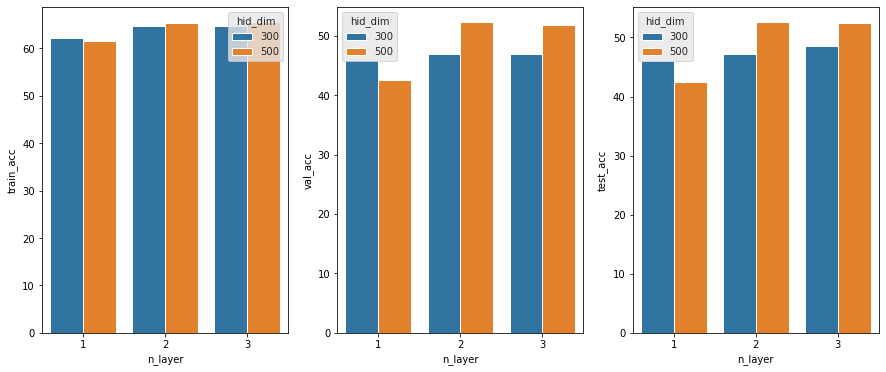

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

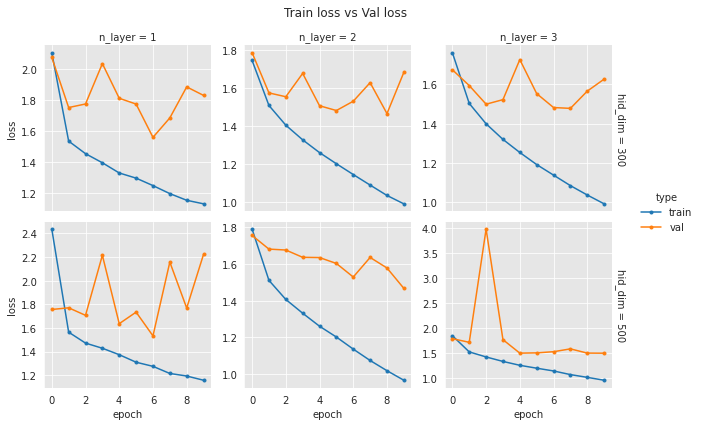

In [16]:

var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

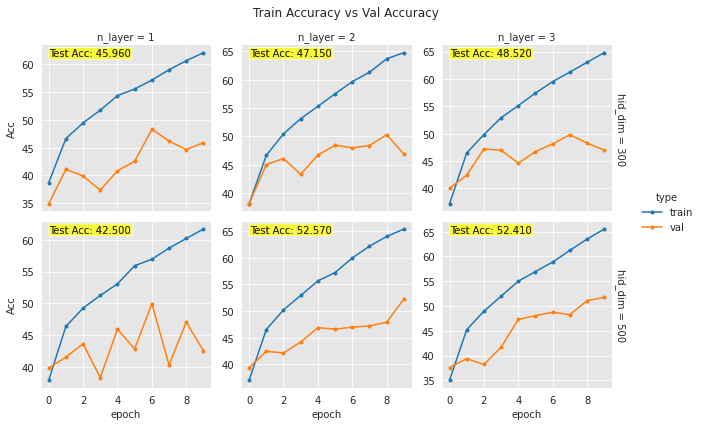

In [17]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [19]:
!ls results
!cat results/exp1_n_layer_hid_dim-41b634.json

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json
{"train_losses": [1.7614429809485272, 1.5028502819644418, 1.3990230173062368, 1.3194924372776298, 1.2528281302968407, 1.1911967749808245, 1.1374797847620242, 1.0838815558488202, 1.0360841284132307, 0.9910942061691527], "val_losses": [1.6743237853050232, 1.593840444087982, 1.498934817314148, 1.522099220752716, 1.7260820865631104, 1.5528184533119203, 1.4818637013435363, 1.4776092052459717, 1.5654655337333678, 1.6266745924949646], "train_accs": [37.1475, 46.45, 49.8075, 52.89, 55.105, 57.41, 59.495, 61.235, 63.03, 64.785], "val_accs": [39.98, 42.41, 47.18, 46.96, 44.57, 46.7, 48.11, 49.79, 48.26, 46.97], "train_acc": 64.785, "val_acc": 46.97, "test_acc": 48.52, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true, "l